In [172]:
import pandas as pd
import numpy as np

In [173]:
df = pd.read_csv('_i-0050be433c08743d0 (1).csv', encoding='UTF-8')

In [174]:
headers = list(df)
headers.remove('Time')
headers

['CPUUtilization',
 'NetworkIn',
 'NetworkOut',
 'DiskReadOps',
 'DiskWriteOps',
 'StatusCheckFailed']

Time is the index. The other metrics are columns.

In [175]:
df.describe()

,CPUUtilization,NetworkIn,NetworkOut,DiskReadOps,DiskWriteOps,StatusCheckFailed
count,168.000000,168.000000,168.000000,168.0,168.0,168.0
mean,0.035534,325.019742,284.134722,0.0,0.0,0.0
std,0.007947,217.853425,474.543471,0.0,0.0,0.0
min,0.030373,273.950000,213.150000,0.0,0.0,0.0
25%,0.033289,282.016667,218.000000,0.0,0.0,0.0
50%,0.033380,290.741667,225.241667,0.0,0.0,0.0
75%,0.033477,319.966667,238.291667,0.0,0.0,0.0
max,0.075661,3049.716667,5917.216667,0.0,0.0,0.0


Consult this doc for more EC2 metrics: https://docs.aws.amazon.com/AWSEC2/latest/UserGuide/viewing_metrics_with_cloudwatch.html
CPU is in %.
NetworkIn and NetworkOut are in bytes per sec.
DiskReadOps and WriteOps are in count.
StatusCheckFailed are either 1 or 0. 1 means failed and 0 means passed. 

## Initial analysis
Time period: 05/23 to 05/29
From the observed summary of instance, we can say that the machine passes both system and instance status check.
The average CPU use hovers around 0.03 % for most of the time since the std is very small. So not that much system CPU use volatility. 

In [176]:
#drops all nan so we only get time period in which there is data
df = df.dropna()
print(list(df.Time)[0]) # start time
print(list(df.Time)[len(list(df.Time)) - 1]) #end time

2019-05-23 00:00:00
2019-05-29 23:00:00


In [177]:
%matplotlib inline
import statsmodels.api as sm
from statsmodels import regression, stats
import statsmodels
import matplotlib.pyplot as plt
import seaborn as sns
import struct

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     7.401
Date:                Mon, 03 Jun 2019   Prob (F-statistic):            0.00721
Time:                        11:54:38   Log-Likelihood:                -1138.7
No. Observations:                 168   AIC:                             2281.
Df Residuals:                     166   BIC:                             2288.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        123.7696     75.794      1.633      0.104     -25.874     273.413
x1          5663.6562   2081.887      2.720      0.007    1553.266    9774.046
==============================================================================
Omnibus:                      363.391   Durbin-Watson:                   2.013
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           176925.302
Skew:                          12.498   Prob(JB):                         0.00
Kurtosis:                     160.004   Cond. No.                         126.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

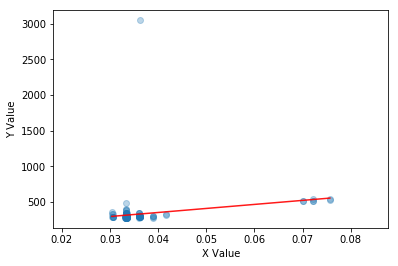

In [178]:
#X and Y would need to be numpy ndarray
#since each column in the dataframe is of Pandas series,
#we convert using Pandas Column.values
def linreg(X,Y):
    # Running the linear regression
    X = sm.add_constant(X)
    model = regression.linear_model.OLS(Y, X).fit()
    #a and b are alpha and beta 
    #in the predictive model
    a = model.params[0]
    b = model.params[1]
    X = X[:, 1]

    # Return summary of the regression and plot results
    X2 = np.linspace(X.min(), X.max(), 100)
    Y_hat = X2 * b + a
    plt.scatter(X, Y, alpha=0.3) # Plot the raw data
    plt.plot(X2, Y_hat, 'r', alpha=0.9);  # Add the regression line, colored in red
    plt.xlabel('X Value')
    plt.ylabel('Y Value')
    #return model.summary()
    #http://www.statsmodels.org/devel/generated/statsmodels.regression.linear_model.RegressionResults.html
    return model
model = linreg(df['CPUUtilization'].values,df['NetworkIn'].values)
model.summary()

In [179]:
print('The f-value statistic is: {}'.format(model.fvalue))
print('The f-value prob statistic is: {}'.format(model.f_pvalue))

The f-value statistic is: 7.400813542089915
The f-value prob statistic is: 0.007214047015688711


### The most important statistic is the F-stat. If F-stat > 0.05 data is NOT SIGNIFICANT. Do not do analysis.
### Only do analysis if f-stat < 0.05
Since the f statistic is 0.07, we can conclude that the data is not significant to analyze.

C:\Users\e389454\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1594: RuntimeWarning: invalid value encountered in double_scalars
  return self.mse_model/self.mse_resid
C:\Users\e389454\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\e389454\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\e389454\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
C:\Users\e389454\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1554: RuntimeWarning: invalid value encountered in double_scalars
  return self.

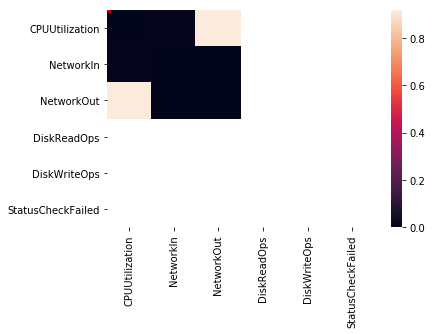

In [181]:
heat_map_df = pd.DataFrame();
headers
for a in headers:
    for b in headers:
        heat_map_df.loc[a,b] = linreg(df[a].values,df[b].values).f_pvalue
        #heat_map_df.loc[a,b] = linreg(df[a].values,df[b].values).fvalue
#heat_map_df
sns.heatmap(heat_map_df)

In [182]:
heat_map_df

,CPUUtilization,NetworkIn,NetworkOut,DiskReadOps,DiskWriteOps,StatusCheckFailed
CPUUtilization,0.000000,7.214047e-03,9.180461e-01,NaN,NaN,NaN
NetworkIn,0.007214,0.000000e+00,2.889626e-68,NaN,NaN,NaN
NetworkOut,0.918046,2.889626e-68,0.000000e+00,NaN,NaN,NaN
DiskReadOps,NaN,NaN,NaN,NaN,NaN,NaN
DiskWriteOps,NaN,NaN,NaN,NaN,NaN,NaN
StatusCheckFailed,NaN,NaN,NaN,NaN,NaN,NaN


Since DiskReadOps, DiskWriteOps and StatusCheckFailed all have 0 filled up in the df. The p value is either inf or -inf. So we can only draw conclusions between CPUUtilization, NetworkIn, NetworkOut. Since NetworkIn and NetworkOut have F-statistic values are under 0.05, we can say that the relationship between NetworkIn and NetworkOut are worth analyzing.

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     880.4
Date:                Mon, 03 Jun 2019   Prob (F-statistic):           2.89e-68
Time:                        12:03:44   Log-Likelihood:                -987.70
No. Observations:                 168   AIC:                             1979.
Df Residuals:                     166   BIC:                             1986.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        205.3717      7.832     26.221      0.000     189.908     220.835
x1             0.4211      0.014     29.672      0.000       0.393       0.449
==============================================================================
Omnibus:                      234.022   Durbin-Watson:                   2.069
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            30928.272
Skew:                          -5.433   Prob(JB):                         0.00
Kurtosis:                      68.576   Cond. No.                         644.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

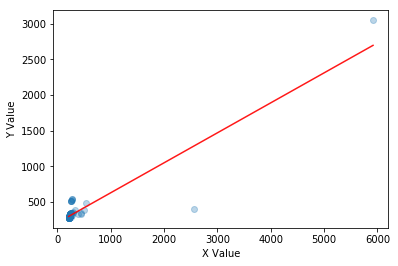

In [186]:
#X is NetworkOut and Y is NetworkIn
linreg(df['NetworkOut'].values,df['NetworkIn'].values).summary()

From the statistical summary, we observed that for every 1 % increased in NetworkIn bytes, 0.42% increases in NetworkOut bytes. 

## Factor model
$$Y = \alpha + \beta_1 X_1 + \beta_2 X_2 + \dots + \beta_n X_n$$
Y is just a linear combination of every other factors or Beta in this case

In [189]:
def linModel(x,y):
    # We add a constant so that we can also fit an intercept (alpha) to the model
    # This just adds a column of 1s to our data
    x = sm.add_constant(x)
    model = regression.linear_model.OLS(y,x).fit()
    # Remove the constant now that we're done
    x = x[:, 1]
    return model.params[0], model.params[1]

alpha, beta = linModel(df['NetworkOut'].values,df['NetworkIn'].values)
print('alpha: ' + str(alpha))
print('beta: ' + str(beta))

alpha: 205.37172069626922
beta: 0.4210960928374176


### Double exponential smoothing function
Source: https://machinelearningmastery.com/exponential-smoothing-for-time-series-forecasting-in-python/
The purpose of this function is to add support for trends in univariate time series. We are going to apply DES for CPU, NetworkIn and NetworkOut. 

In [196]:
# double exponential smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
CPU_data = list(df['CPUUtilization'])
CPU_model = ExponentialSmoothing(CPU_data)
CPU_fit = CPU_model.fit()
yhat = CPU_fit.predict(len(CPU_data), len(CPU_data))
print("The next predicted CPU Utilization is: ", yhat)

The next predicted CPU Utilization is:  [0.03553345]


In [203]:
#https://stackoverflow.com/questions/53059876/double-exponential-smoothing-des-yields-different-results-in-r-and-python
#code for double smoothing model
import statsmodels.tsa.holtwinters as ets
holt_r = ets.ExponentialSmoothing(CPU_data, trend="additive", damped=False, seasonal=None).fit()
holt_r.forecast(1)

array([0.03553363])

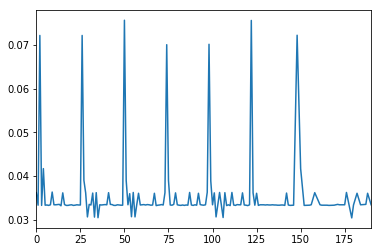

In [204]:
df['CPUUtilization'].plot()

From initial observation, we can say that the time series data for CPU Utilization does not have a trend nor a seasonality.

In [206]:
#source: https://machinelearningmastery.com/how-to-grid-search-triple-exponential-smoothing-for-time-series-forecasting-in-python/
#based upon case study 1
# grid search ets models for daily female births
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from pandas import read_csv
from numpy import array

# one-step Holt Winter’s Exponential Smoothing forecast
# history takes in a Pandas series like a DF's column
def exp_smoothing_forecast(history, config):
    t,d,s,p,b,r = config
    
    # define model
    history = array(history)
    model = ExponentialSmoothing(history, trend=t, damped=d, seasonal=s, seasonal_periods=p)
    
    # fit model
    model_fit = model.fit(optimized=True, use_boxcox=b, remove_bias=r)
    
    # make one step forecast
    yhat = model_fit.predict(len(history), len(history))
    return yhat[0]

# root mean squared error or rmse
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
    predictions = list()
    
    # split dataset
    train, test = train_test_split(data, n_test)
    
    # seed history with training dataset
    history = [x for x in train]
    
    # step over each time-step in the test set
    for i in range(len(test)):
        
        # fit model and make forecast for history
        yhat = exp_smoothing_forecast(history, cfg)
        
        # store forecast in list of predictions
        predictions.append(yhat)
        
        # add actual observation to history for the next loop
        history.append(test[i])
        
        # estimate prediction error
        error = measure_rmse(test, predictions)
        return error

# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
    result = None
    
    # convert config to a key
    key = str(cfg)
    
    # show all warnings and fail on exception if debugging
    if debug:
        result = walk_forward_validation(data, n_test, cfg)
    else:
        # one failure during model validation suggests an unstable config
        try:
            # never show warnings when grid searching, too noisy
            with catch_warnings():
                filterwarnings("ignore")
                result = walk_forward_validation(data, n_test, cfg)
        except:
            error = None

    # check for an interesting result
    if result is not None:
        print(' > Model[%s] %.3f' % (key, result))
    return (key, result)

# grid search configs
def grid_search(data, cfg_list, n_test, parallel=True):
    scores = None
    if parallel:
        # execute configs in parallel
        executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
        tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list)
        scores = executor(tasks)
    else:
        scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
    # remove empty results
    scores = [r for r in scores if r[1] != None]
    # sort configs by error, asc
    scores.sort(key=lambda tup: tup[1])
    return scores

# create a set of exponential smoothing configs to try
def exp_smoothing_configs(seasonal=[None]):
    models = list()
    # define config lists
    t_params = ['add', 'mul', None]
    d_params = [True, False]
    s_params = ['add', 'mul', None]
    p_params = seasonal
    b_params = [True, False]
    r_params = [True, False]
    # create config instances
    for t in t_params:
        for d in d_params:
            for s in s_params:
                for p in p_params:
                    for b in b_params:
                        for r in r_params:
                            cfg = [t,d,s,p,b,r]
                            models.append(cfg)
    return models

# we know that there are 168 datapoints for CPU Util data
# so we are going to split the training data to be 70 %

CPU_data = df['CPUUtilization']

# data split
n_test = len(df['CPUUtilization']) * 0.7

# model configs
cfg_list = exp_smoothing_configs()

# grid search
scores = grid_search(data[:,0], cfg_list, n_test)
print('done')

# list top 3 configs
for cfg, error in scores[:3]:
    print(cfg, error)

ModuleNotFoundError: No module named 'joblib'

In [208]:
import os
path = os.path.dirname(pd.__file__)
path

'C:\\Users\\e389454\\AppData\\Local\\Continuum\\anaconda3\\lib\\site-packages\\pandas'

In [209]:
from pandas import read_csv
series = read_csv('_i-0050be433c08743d0 (1).csv', encoding='UTF-8')
data = series.values
data

array([['2019-05-23 00:00:00', 0.03615973572905933, 288.3666666666667,
        ..., 0.0, 0.0, 0.0],
       ['2019-05-23 01:00:00', 0.03328779599271522, 286.3, ..., 0.0, 0.0,
        0.0],
       ['2019-05-23 02:00:00', 0.07217822852026548, 517.3166666666667,
        ..., 0.0, 0.0, 0.0],
       ...,
       ['2019-09-05 21:00:00', nan, nan, ..., nan, nan, nan],
       ['2019-09-05 22:00:00', nan, nan, ..., nan, nan, nan],
       ['2019-09-05 23:00:00', nan, nan, ..., nan, nan, nan]],
      dtype=object)

In [210]:
data[:,0]

array(['2019-05-23 00:00:00', '2019-05-23 01:00:00',
       '2019-05-23 02:00:00', ..., '2019-09-05 21:00:00',
       '2019-09-05 22:00:00', '2019-09-05 23:00:00'], dtype=object)

In [213]:
series = read_csv('daily-total-female-births.csv', encoding='UTF-8',header=0, index_col=0)
data = series.values
data

array([[35],
       [32],
       [30],
       [31],
       [44],
       [29],
       [45],
       [43],
       [38],
       [27],
       [38],
       [33],
       [55],
       [47],
       [45],
       [37],
       [50],
       [43],
       [41],
       [52],
       [34],
       [53],
       [39],
       [32],
       [37],
       [43],
       [39],
       [35],
       [44],
       [38],
       [24],
       [23],
       [31],
       [44],
       [38],
       [50],
       [38],
       [51],
       [31],
       [31],
       [51],
       [36],
       [45],
       [51],
       [34],
       [52],
       [47],
       [45],
       [46],
       [39],
       [48],
       [37],
       [35],
       [52],
       [42],
       [45],
       [39],
       [37],
       [30],
       [35],
       [28],
       [45],
       [34],
       [36],
       [50],
       [44],
       [39],
       [32],
       [39],
       [45],
       [43],
       [39],
       [31],
       [27],
       [30],
       [42],
       [46],

In [219]:
data[:,0]

array([35, 32, 30, 31, 44, 29, 45, 43, 38, 27, 38, 33, 55, 47, 45, 37, 50,
       43, 41, 52, 34, 53, 39, 32, 37, 43, 39, 35, 44, 38, 24, 23, 31, 44,
       38, 50, 38, 51, 31, 31, 51, 36, 45, 51, 34, 52, 47, 45, 46, 39, 48,
       37, 35, 52, 42, 45, 39, 37, 30, 35, 28, 45, 34, 36, 50, 44, 39, 32,
       39, 45, 43, 39, 31, 27, 30, 42, 46, 41, 36, 45, 46, 43, 38, 34, 35,
       56, 36, 32, 50, 41, 39, 41, 47, 34, 36, 33, 35, 38, 38, 34, 53, 34,
       34, 38, 35, 32, 42, 34, 46, 30, 46, 45, 54, 34, 37, 35, 40, 42, 58,
       51, 32, 35, 38, 33, 39, 47, 38, 52, 30, 34, 40, 35, 42, 41, 42, 38,
       24, 34, 43, 36, 55, 41, 45, 41, 37, 43, 39, 33, 43, 40, 38, 45, 46,
       34, 35, 48, 51, 36, 33, 46, 42, 48, 34, 41, 35, 40, 34, 30, 36, 40,
       39, 45, 38, 47, 33, 30, 42, 43, 41, 41, 59, 43, 45, 38, 37, 45, 42,
       57, 46, 51, 41, 47, 26, 35, 44, 41, 42, 36, 45, 45, 45, 47, 38, 42,
       35, 36, 39, 45, 43, 47, 36, 41, 50, 39, 41, 46, 64, 45, 34, 38, 44,
       48, 46, 44, 37, 39

In [221]:
df['CPUUtilization'].values

array([0.03615974, 0.0332878 , 0.07217823, 0.03324226, 0.04166821,
       0.03328934, 0.03333488, 0.0332438 , 0.03338196, 0.03629944,
       0.03338505, 0.03338196, 0.03342904, 0.03347766, 0.03315118,
       0.03611265, 0.03342904, 0.03324226, 0.0332438 , 0.03333488,
       0.03338041, 0.03324226, 0.03328934, 0.03338196, 0.03333333,
       0.03333333, 0.07217668, 0.03898305, 0.0361142 , 0.03060264,
       0.03347458, 0.03333333, 0.03606712, 0.03055864, 0.03615974,
       0.03042049, 0.03338041, 0.03333642, 0.03338196, 0.0334275 ,
       0.03338041, 0.03615819, 0.03347458, 0.0334275 , 0.0332438 ,
       0.03324226, 0.03338041, 0.03333642, 0.03328934, 0.03328934,
       0.07566068, 0.03893597, 0.0333835 , 0.03592896, 0.03064972,
       0.03620527, 0.03060418, 0.03342904, 0.03602158, 0.03333642,
       0.03338041, 0.0334275 , 0.03333488, 0.03342904, 0.03338196,
       0.03328934, 0.03333333, 0.03602004, 0.03319672, 0.03328934,
       0.03333488, 0.0334275 , 0.03333333, 0.03616128, 0.07005